# <center> <B> DA4210 - Text Analytics </B> </center>

### <center> <B> Assignment 02 </B> </center>


### <center> <B> Leveraging Text Analytics for Stock Market Trading </B> </center>


Group 05 Members: </br>
</br>
1. 206121X - M. W. S. A. U. SILVA <br>
2. 206037U - H.P.S.B. Gunarathna <br>
3. 206038A - U.N.D.Gunasekara <br>
4. 206146D - B.A.T.Yashodha <br>
5. 206096X - P.D.T.Poornima <br>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import libraries

import os
import warnings

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Preprocessing ---> tokenize/ stopwords/ lemmatizer

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay)

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


**Create the dataset**

In [3]:
# Load Dataset

tweet = pd.read_csv("/content/drive/MyDrive/7_Semester/Text_Analytics/Assignment 2/stock_tweets.csv")
stock = pd.read_csv("/content/drive/MyDrive/7_Semester/Text_Analytics/Assignment 2/stock_yfinance_data.csv")

In [4]:
tweet = tweet.loc[tweet['Stock Name'] == "TSLA"]
tweet.shape

(37422, 4)

In [5]:
tweet.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [6]:
# Seperate Date & Time in Tweet dataset
tweet[['date', 'time']] = tweet['Date'].str.split(' ', expand=True)
tweets = tweet.drop(columns=['Date'])
tweets.head()

,Tweet,Stock Name,Company Name,date,time
0,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",2022-09-29,23:41:16+00:00
1,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",2022-09-29,23:24:43+00:00
2,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",2022-09-29,23:18:08+00:00
3,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",2022-09-29,22:40:07+00:00
4,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.",2022-09-29,22:27:05+00:00


In [7]:
# Sort dates
tweets = tweets.sort_values(by='date')
tweets.head()

,Tweet,Stock Name,Company Name,date,time
37421,"In other words, AMD has been giving Tesla pref...",TSLA,"Tesla, Inc.",2021-09-30,01:16:13+00:00
37355,Screw these manipulative MM bitches. I'm in fo...,TSLA,"Tesla, Inc.",2021-09-30,19:10:10+00:00
37356,I forgot today was the last day of the qtr. Ty...,TSLA,"Tesla, Inc.",2021-09-30,19:06:08+00:00
37357,Look at this footage of @Tesla #FSD #Autopilot...,TSLA,"Tesla, Inc.",2021-09-30,18:55:17+00:00
37358,Has anyone ever published a credible explanati...,TSLA,"Tesla, Inc.",2021-09-30,18:44:41+00:00


In [8]:
# Merge tweets under dates
# Creating DataFrame
df = pd.DataFrame(tweets)

# Convert 'date' column to datetime for accurate processing
df['date'] = pd.to_datetime(df['date'])

# Group by 'date' and 'stock', then concatenate tweets
grouped_df = df.groupby(['date', 'Stock Name'])['Tweet'].agg(lambda x: ' '.join(x)).reset_index()

# Rename the concatenated column to something more descriptive if desired
grouped_df.rename(columns={'Tweet': 'combined_tweets'}, inplace=True)

# Save the result to a CSV file without row numbers (index)
grouped_df.to_csv('grouped_tweets.csv', index=False)

# Display the resulting tweetsFrame
print("Grouped tweetsFrame:")
print(grouped_df)

Grouped tweetsFrame:
          date Stock Name                                    combined_tweets
0   2021-09-30       TSLA  In other words, AMD has been giving Tesla pref...
1   2021-10-01       TSLA  You’re eyes aren’t deceiving you. That’s almos...
2   2021-10-02       TSLA  I remember being stoked when tesla delivered 8...
3   2021-10-03       TSLA  @kitjones9 @Tesla @elonmusk @SpaceX Good luck ...
4   2021-10-04       TSLA  $TSLA\nToday's rejection at 800 -807 area give...
..         ...        ...                                                ...
360 2022-09-25       TSLA  Year-to-Date Performance:\n\n1. $FB: -59%\n2. ...
361 2022-09-26       TSLA  I had my first ride in a $RIVN over the weeken...
362 2022-09-27       TSLA  Huge FED problem that the investors are favori...
363 2022-09-28       TSLA  I’M READY FOR TESLA AI DAY + Q3 PRODUCTION &am...
364 2022-09-29       TSLA  @TeslaSolar roof stood up to #HurricaneIan wit...

[365 rows x 3 columns]


In [9]:
# Convert 'date' column to string before concatenating
grouped_df['date_str'] = grouped_df['date'].dt.strftime('%Y-%m-%d')

# Create a unique key by concatenating 'date_str' and 'Stock Name'
grouped_df['unique_key'] = grouped_df['date_str'] + '_' + grouped_df['Stock Name']

In [10]:
grouped_df.head()

,date,Stock Name,combined_tweets,date_str,unique_key
0,2021-09-30,TSLA,"In other words, AMD has been giving Tesla pref...",2021-09-30,2021-09-30_TSLA
1,2021-10-01,TSLA,You’re eyes aren’t deceiving you. That’s almos...,2021-10-01,2021-10-01_TSLA
2,2021-10-02,TSLA,I remember being stoked when tesla delivered 8...,2021-10-02,2021-10-02_TSLA
3,2021-10-03,TSLA,@kitjones9 @Tesla @elonmusk @SpaceX Good luck ...,2021-10-03,2021-10-03_TSLA
4,2021-10-04,TSLA,$TSLA\nToday's rejection at 800 -807 area give...,2021-10-04,2021-10-04_TSLA


In [11]:
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [12]:
stock["date"] = stock["Date"]
stock = stock.drop(columns=["Date"])
stock.head()

,Open,High,Low,Close,Adj Close,Volume,Stock Name,date
0,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA,2021-09-30
1,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA,2021-10-01
2,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA,2021-10-04
3,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA,2021-10-05
4,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA,2021-10-06


In [13]:
# Create a unique key by concatenating 'Date' and 'Stock Name'
grouped_df['unique_key'] = grouped_df['date_str'] + '_' + grouped_df['Stock Name']
stock['unique_key'] = stock['date'] + '_' + stock['Stock Name']

# Merge the datasets on the unique key
merged_df = pd.merge(grouped_df, stock, on='unique_key')

# Drop the unique_key column if it's no longer needed
merged_df = merged_df.drop(columns=['unique_key'])

# Save the merged dataset to a new CSV file
merged_df.to_csv('merged_dataset.csv', index=False)

# Display the first few rows of the merged dataset
print(merged_df.head())

      date_x Stock Name_x                                    combined_tweets  \
0 2021-09-30         TSLA  In other words, AMD has been giving Tesla pref...   
1 2021-10-01         TSLA  You’re eyes aren’t deceiving you. That’s almos...   
2 2021-10-04         TSLA  $TSLA\nToday's rejection at 800 -807 area give...   
3 2021-10-05         TSLA  L6: A company’s P/E is based on future expecte...   
4 2021-10-06         TSLA  The day $GM catches up or even gets close to $...   

     date_str        Open        High         Low       Close   Adj Close  \
0  2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1  2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2  2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3  2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4  2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   

     Volume Stock Name_y      date_y  
0  53868000      

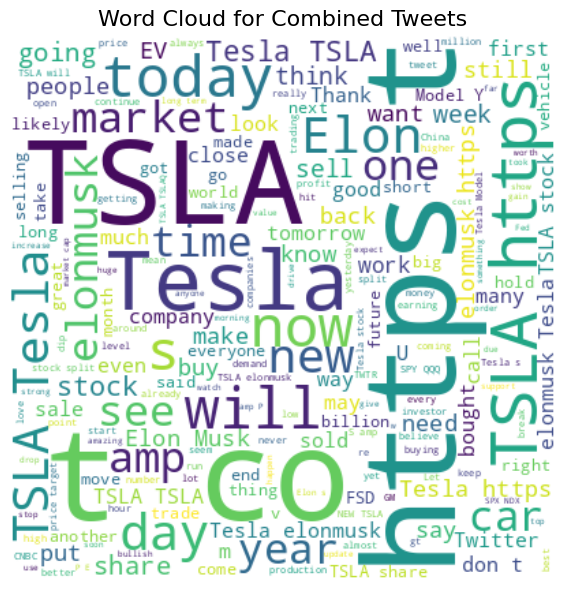

In [14]:
all_tweets = ' '.join(merged_df['combined_tweets'].values)

# Generate the word cloud
wordcloud_merged = WordCloud(width=400, height=400, background_color='white').generate(all_tweets)

# Plot the word cloud
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_merged, interpolation='bilinear')
plt.title('Word Cloud for Combined Tweets', fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()

## **Data Preprocessing**

In [15]:
# Delet uneeded columns
merged_df = merged_df.drop(columns = ["Stock Name_x", "date_str", "Adj Close", "Stock Name_y", "date_y"])

In [16]:
# check for cleaning data
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date_x           252 non-null    datetime64[ns]
 1   combined_tweets  252 non-null    object        
 2   Open             252 non-null    float64       
 3   High             252 non-null    float64       
 4   Low              252 non-null    float64       
 5   Close            252 non-null    float64       
 6   Volume           252 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 13.9+ KB


In [17]:
# Remove null values
merged_df.isnull().sum()

date_x             0
combined_tweets    0
Open               0
High               0
Low                0
Close              0
Volume             0
dtype: int64

In [18]:
# Remove duplicates
merged_df.duplicated().sum()

0

In [19]:
def process_text(combined_tweets):

    # Remove extra white space from text
    combined_tweets = re.sub(r'\s+', ' ', combined_tweets, flags=re.I)

    # Remove URLs
    def remove_URL(text):
      url = re.compile(r'https?://\S+|www\.\S+')
      return url.sub(r'',text)
    merged_df['combined_tweets'] = merged_df['combined_tweets'].apply(lambda x : remove_URL(x))

    # Remove HTML tags
    def remove_html(text):
      html=re.compile(r'<.*?>')
      return html.sub(r'',text)
    merged_df['combined_tweets'] = merged_df['combined_tweets'].apply(lambda x : remove_html(x))

    # Remove all the special characters from text
    combined_tweets = re.sub(r'\W', ' ', str(combined_tweets))

    # Remove all single characters from text
    combined_tweets = re.sub(r'\s+[a-zA-Z]\s+', ' ', combined_tweets)

    # Remove any character that isn't alphabetical
    combined_tweets = re.sub(r'[^a-zA-Z\s]', '', combined_tweets)

    # Lowercasing
    combined_tweets = combined_tweets.lower()

    #Tokenization
    words = word_tokenize(combined_tweets)

    #Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    Words = [word for word in words if word not in stop_words]

    indices = np.unique(words, return_index=True)[1]
    cleaned_text = np.array(words)[np.sort(indices)].tolist()
    cleaned_combined_tweets = ' '.join(cleaned_text)

    return cleaned_combined_tweets

In [20]:
merged_df['Cleaned_Tweets'] = merged_df['combined_tweets'].apply(process_text)

In [21]:
merged_df.head()

,date_x,combined_tweets,Open,High,Low,Close,Volume,Cleaned_Tweets
0,2021-09-30,"In other words, AMD has been giving Tesla pref...",260.333344,263.043335,258.333344,258.493347,53868000,in other word amd ha been giving tesla prefere...
1,2021-10-01,You’re eyes aren’t deceiving you. That’s almos...,259.466675,260.260010,254.529999,258.406677,51094200,you re eye aren deceiving that almost thousand...
2,2021-10-04,$TSLA\nToday's rejection at 800 -807 area give...,265.500000,268.989990,258.706665,260.510010,91449900,tsla today rejection at area give more convict...
3,2021-10-05,L6: A company’s P/E is based on future expecte...,261.600006,265.769989,258.066681,260.196655,55297800,l company p is based on future expected growth...
4,2021-10-06,The day $GM catches up or even gets close to $...,258.733337,262.220001,257.739990,260.916656,43898400,the day gm catch up or even get close to tsla ...


In [22]:
final_df = merged_df.drop(columns = ["combined_tweets"])
final_df.head()

,date_x,Open,High,Low,Close,Volume,Cleaned_Tweets
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,53868000,in other word amd ha been giving tesla prefere...
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,51094200,you re eye aren deceiving that almost thousand...
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,91449900,tsla today rejection at area give more convict...
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,55297800,l company p is based on future expected growth...
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,43898400,the day gm catch up or even get close to tsla ...


In [23]:
final_df.to_csv('final_df.csv', index = False)

## **Sentiment Analysis**

In [24]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.3 MB/s eta 0:00:00


In [25]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to analyze sentiment using VADER
def analyze_sentiment_vader(text):
    scores = analyzer.polarity_scores(text)
    sentiment = 'POSITIVE' if scores['compound'] >= 0.05 else ('NEGATIVE' if scores['compound'] <= -0.05 else 'NEUTRAL')
    return sentiment, scores['compound']

# Apply VADER sentiment analysis to each tweet in the dataframe
final_df['Sentiment'], final_df['Sentiment_Score'] = zip(*final_df['Cleaned_Tweets'].apply(analyze_sentiment_vader))

# Display the DataFrame with sentiment scores
final_df.head()

,date_x,Open,High,Low,Close,Volume,Cleaned_Tweets,Sentiment,Sentiment_Score
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,53868000,in other word amd ha been giving tesla prefere...,POSITIVE,0.9995
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,51094200,you re eye aren deceiving that almost thousand...,POSITIVE,0.9980
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,91449900,tsla today rejection at area give more convict...,POSITIVE,0.9981
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,55297800,l company p is based on future expected growth...,POSITIVE,0.9956
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,43898400,the day gm catch up or even get close to tsla ...,POSITIVE,0.9986


Correlation between Sentiment Score and Close price: 0.22765177435583678


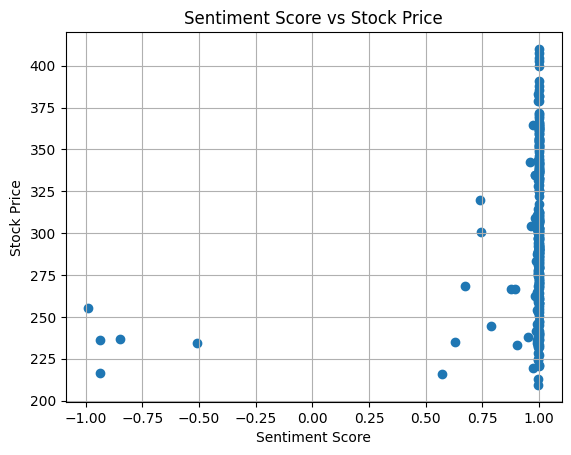

In [26]:
# Correlation Analysis

# Calculate the correlation between Sentiment_Score and Close price
correlation = final_df['Sentiment_Score'].corr(final_df['Close'])
print(f'Correlation between Sentiment Score and Close price: {correlation}')

plt.scatter(final_df['Sentiment_Score'], final_df['Close'])
plt.title('Sentiment Score vs Stock Price')
plt.xlabel('Sentiment Score')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()

<Axes: xlabel='Sentiment_Score', ylabel='Close'>

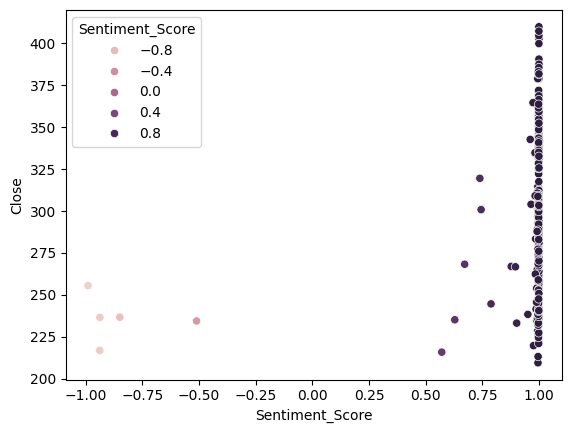

In [27]:
sns.scatterplot(data=final_df, x='Sentiment_Score', y='Close', hue='Sentiment_Score')

In [28]:
# Define stock price movement
final_df['Price_Movement'] = final_df['Close'].diff().apply(lambda x: 'UP' if x > 0 else ('DOWN' if x < 0 else 'STABLE'))

# Compare sentiment with stock price movement
movement_sentiment = final_df.groupby(['Price_Movement', 'Sentiment']).size().unstack(fill_value=0)
print(movement_sentiment)

Sentiment       NEGATIVE  POSITIVE
Price_Movement                    
DOWN                   4       114
STABLE                 0         1
UP                     1       132


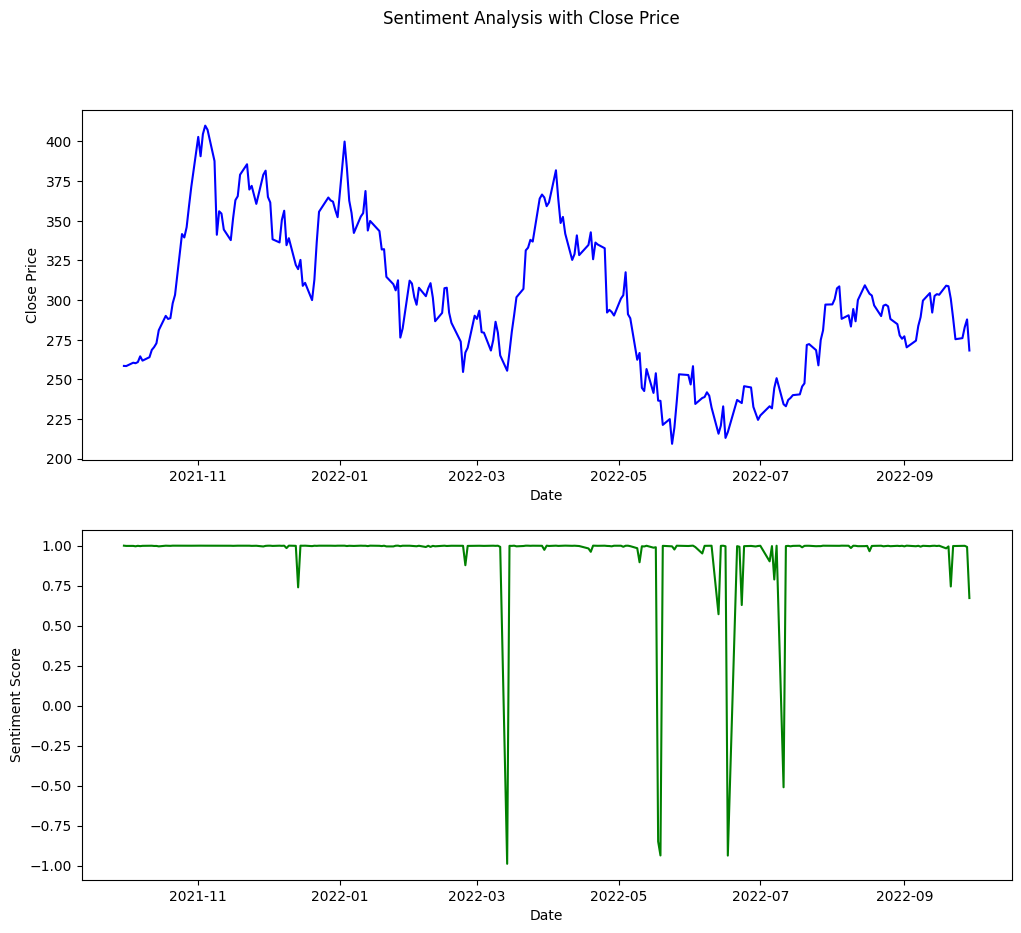

In [29]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, figsize=(12, 10))
fig.suptitle('Sentiment Analysis with Close Price')
axs[0].plot(final_df['date_x'], final_df['Close'], color='blue')
#axs[0].set_title('Close Price')
axs[0].set(xlabel='Date', ylabel='Close Price')
axs[1].plot(final_df['date_x'], final_df['Sentiment_Score'], color='green')
#axs[1].set_title('Sentiment Score')
axs[1].set(xlabel='Date', ylabel='Sentiment Score')
plt.show()
# Plotting sentiment scores and close price
#plt.figure(figsize=(12, 6))
#plt.plot()
#plt.xlabel('Index')
#plt.ylabel('Value')
#plt.title('Sentiment Analysis with Close Price')


## **Model Building and Selection**

In [30]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = final_df #pd.read_csv('/content/drive/MyDrive/Assignment 2/vader_sentiment_analysis_results.csv')
data.head()


,date_x,Open,High,Low,Close,Volume,Cleaned_Tweets,Sentiment,Sentiment_Score,Price_Movement
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,53868000,in other word amd ha been giving tesla prefere...,POSITIVE,0.9995,STABLE
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,51094200,you re eye aren deceiving that almost thousand...,POSITIVE,0.9980,DOWN
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,91449900,tsla today rejection at area give more convict...,POSITIVE,0.9981,UP
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,55297800,l company p is based on future expected growth...,POSITIVE,0.9956,DOWN
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,43898400,the day gm catch up or even get close to tsla ...,POSITIVE,0.9986,UP


In [31]:
# Define the target variable
data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)
data.dropna()
data.shape

(252, 11)

In [32]:
def df_convert_to_trainable(df, features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Sentiment_Score']):
  return df[features], df["Target"], df[[x for x in df.columns if x not in features]]

X, y, extra_info = df_convert_to_trainable(data)


In [33]:
#test_train_split = extra_info["date_x"]>'2022-07-01'
#train_X, test_X = X[~test_train_split], X[test_train_split]
#train_y, test_y = y[~test_train_split], y[test_train_split]
#train_extra_info, test_extra_info = extra_info[~test_train_split], extra_info[test_train_split]
#train_y.value_counts(), test_y.value_counts()

In [34]:
# Split into training and test sets
X_train, X_test, y_train, y_test, extra_info_train, extra_info_test = train_test_split(X, y, extra_info, test_size=0.2, random_state=42, shuffle=False)

<Axes: xlabel='date_x', ylabel='Close'>

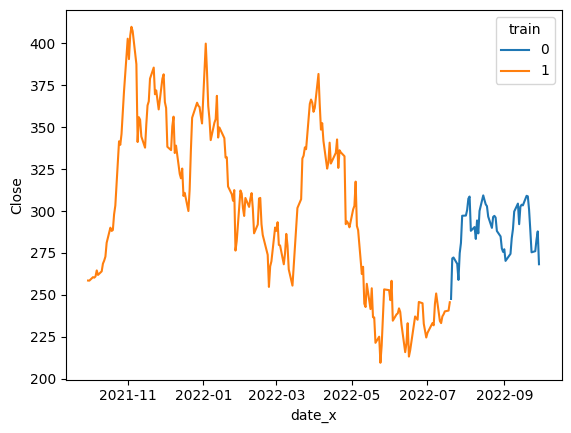

In [35]:
train_date_close = X_train.copy()
train_date_close["date_x"] = extra_info_train["date_x"]
train_date_close["train"] = 1

test_date_close = X_test.copy()
test_date_close["date_x"] = extra_info_test["date_x"]
test_date_close["train"] = 0

combined_df = pd.concat([train_date_close,test_date_close], axis=0)

sns.lineplot(data=combined_df, x='date_x', y='Close', hue='train')

In [36]:
# Train and Evaluate Multiple Models

# Function to train and evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    return accuracy, precision, recall, f1, rmse

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Evaluate models
results = {}
for model_name, model in models.items():
    results[model_name] = evaluate_model(model, X_train, X_test, y_train, y_test)

# Display results
results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'RMSE'])
results_df.T


,Accuracy,Precision,Recall,F1-Score,RMSE
Logistic Regression,0.529412,0.529412,1.000000,0.692308,0.685994
Random Forest,0.549020,0.547619,0.851852,0.666667,0.671551
Decision Tree,0.450980,0.481481,0.481481,0.481481,0.740959
K-Nearest Neighbors,0.490196,0.513514,0.703704,0.593750,0.714006


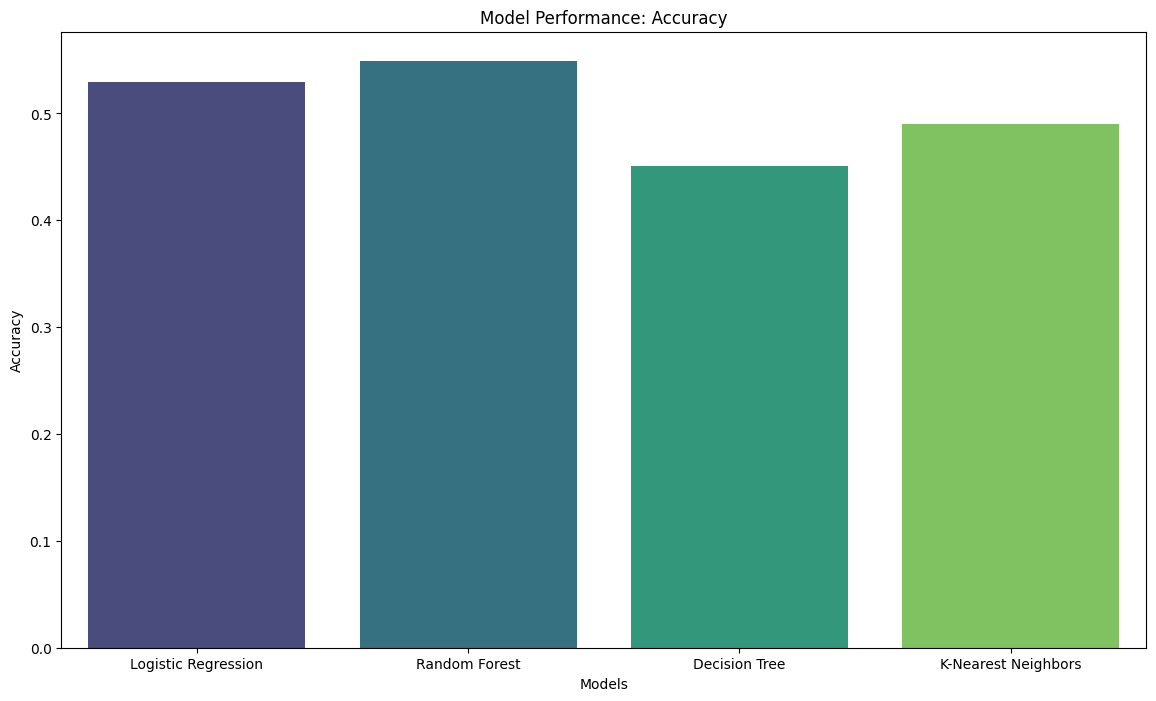

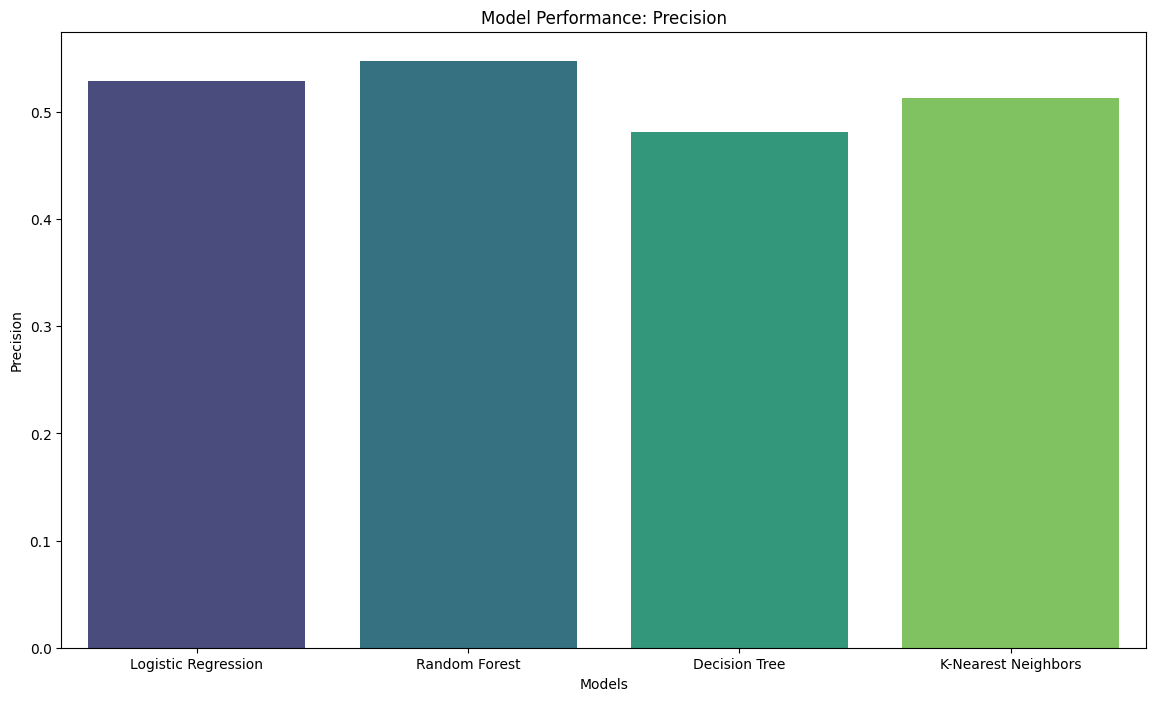

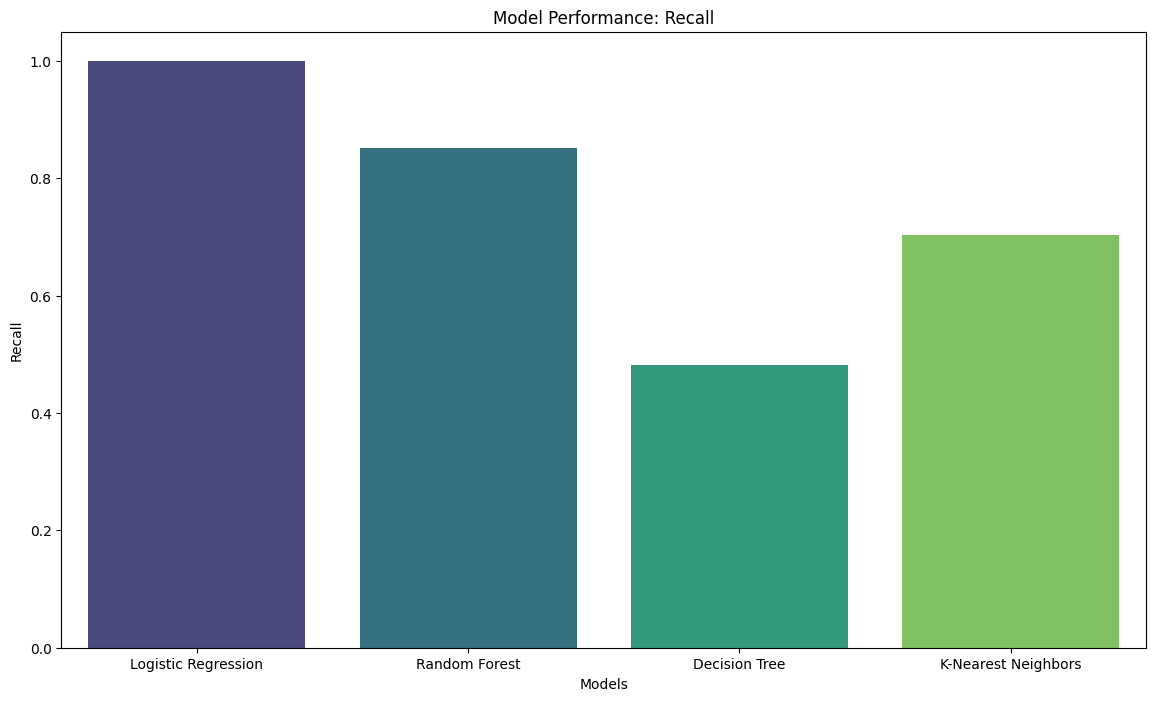

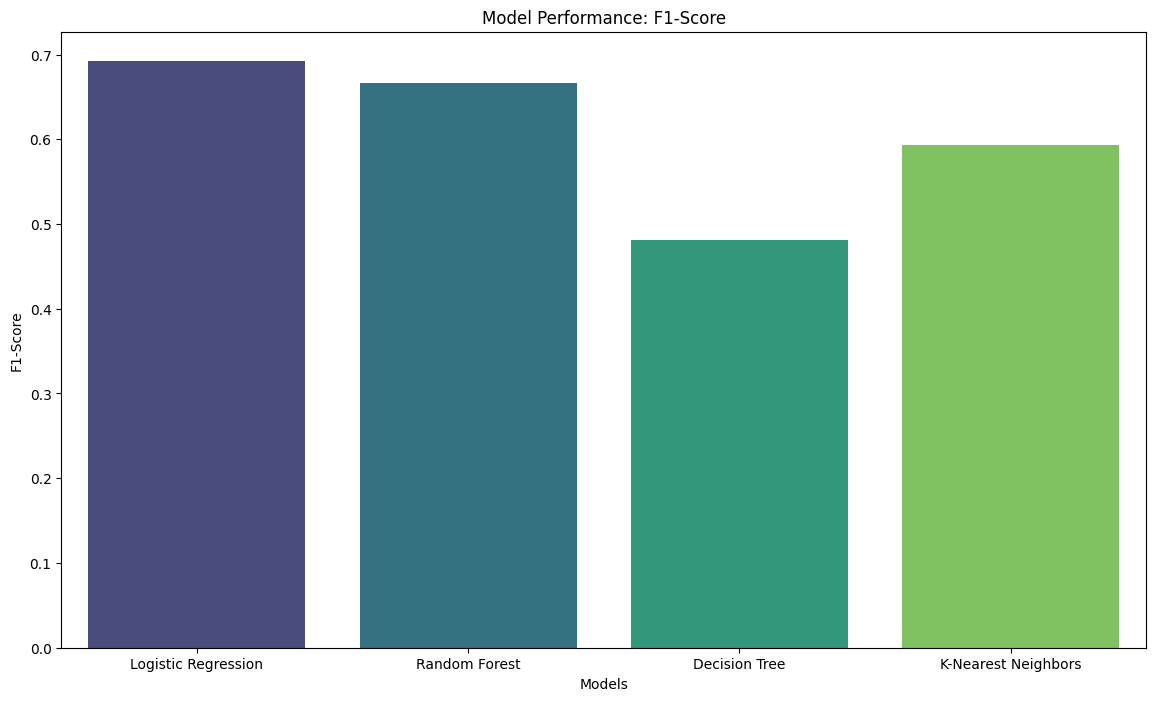

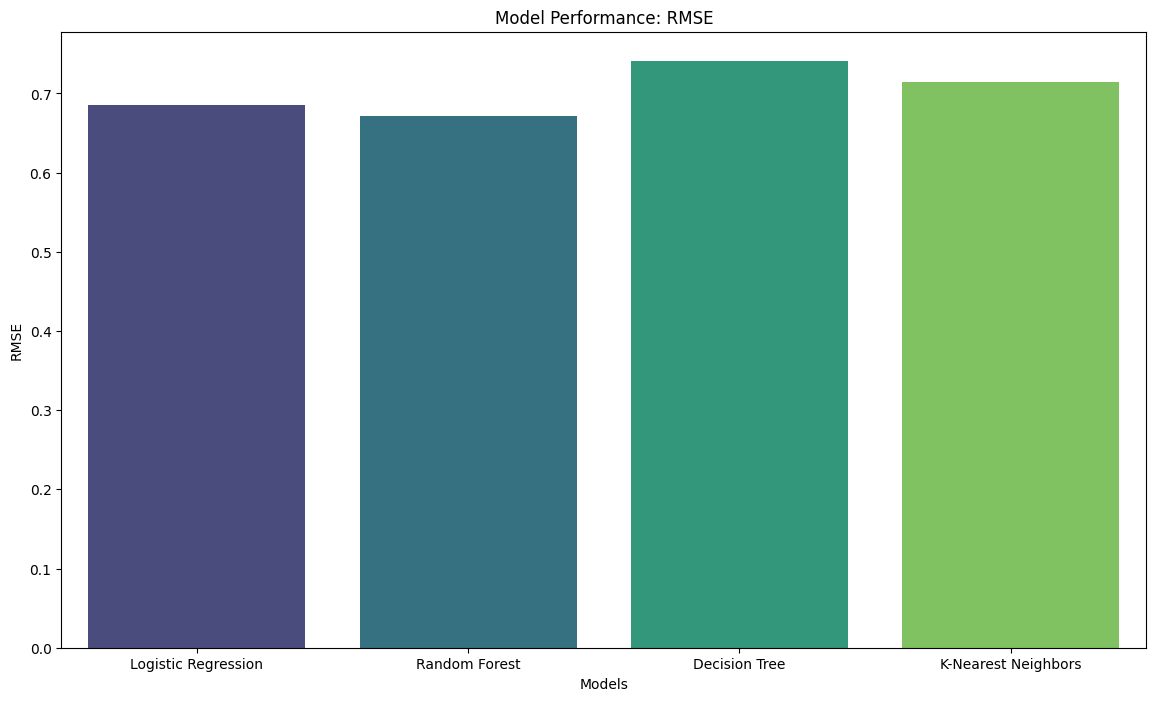

In [37]:
for metric in ['Accuracy', "Precision", "Recall", "F1-Score", "RMSE"]:

  # Plotting the performance of the models
  plt.figure(figsize=(14, 8))
  sns.barplot(x=results_df.columns, y=results_df.loc[metric], palette='viridis')
  plt.title(f'Model Performance: {metric}')
  plt.xlabel('Models')
  plt.ylabel(f'{metric}')
  plt.show()

In [38]:
# we choose Random forest as our main classifier from this point forward

main_model = models["Random Forest"]
predictions = model.predict(X_test)
predictions = pd.DataFrame(data=predictions, columns=["Predicted_Labels"], index= X_test.index)
predictions["Predicted_Labels"] = predictions["Predicted_Labels"].astype(float)

test_data = X_test.copy()
test_data["Actual_Labels"] = y_test
test_data['Date'] = extra_info_test["date_x"]

## **Evaluation of Model Performance:**

Accuracy: 0.49
              precision    recall  f1-score   support

           0       0.43      0.25      0.32        24
           1       0.51      0.70      0.59        27

    accuracy                           0.49        51
   macro avg       0.47      0.48      0.45        51
weighted avg       0.47      0.49      0.46        51



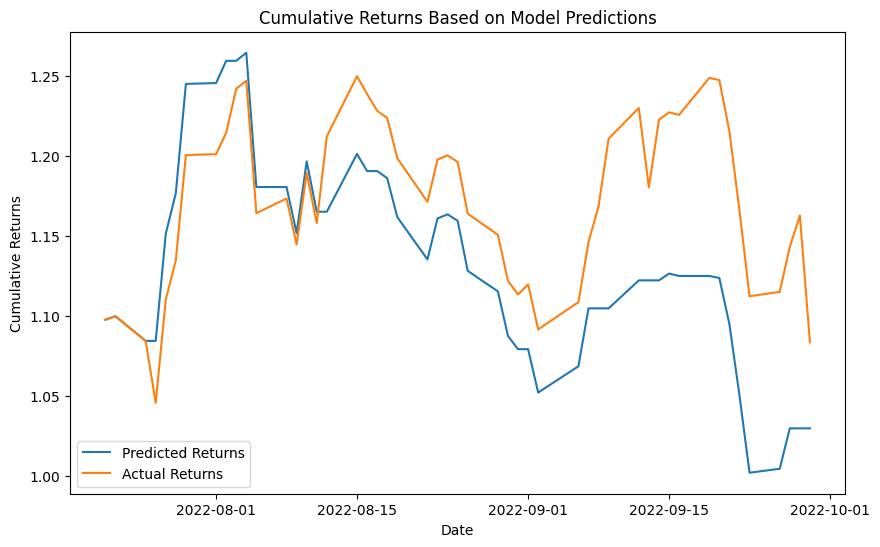

Mean Predicted Return: 0.0009
Standard Deviation Predicted Return: 0.0271
Mean Actual Return: 0.0021
Standard Deviation Actual Return: 0.0319


In [40]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

test_data['Predicted_Returns'] = test_data['Close'].pct_change() * predictions['Predicted_Labels']

# Calculate actual returns
test_data['Actual_Returns'] = test_data['Close'].pct_change()

# Evaluate the model
accuracy = accuracy_score(test_data['Actual_Labels'], predictions['Predicted_Labels'])
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(test_data['Actual_Labels'], predictions['Predicted_Labels']))

# Analyze potential gains and variability of profitability
# Calculate cumulative returns based on predictions
test_data['Cumulative_Returns'] = (test_data['Predicted_Returns'] + 1).cumprod()

# Calculate cumulative returns based on actual labels
test_data['Cumulative_Actual_Returns'] = (test_data['Actual_Returns'] + 1).cumprod()

# Plot cumulative returns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_data['Date'], test_data['Cumulative_Returns'], label='Predicted Returns')
plt.plot(test_data['Date'], test_data['Cumulative_Actual_Returns'], label='Actual Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Based on Model Predictions')
plt.legend()
plt.show()

# Calculate statistics
mean_predicted_return = test_data['Predicted_Returns'].mean()
std_predicted_return = test_data['Predicted_Returns'].std()
mean_actual_return = test_data['Actual_Returns'].mean()
std_actual_return = test_data['Actual_Returns'].std()

print(f'Mean Predicted Return: {mean_predicted_return:.4f}')
print(f'Standard Deviation Predicted Return: {std_predicted_return:.4f}')
print(f'Mean Actual Return: {mean_actual_return:.4f}')
print(f'Standard Deviation Actual Return: {std_actual_return:.4f}')

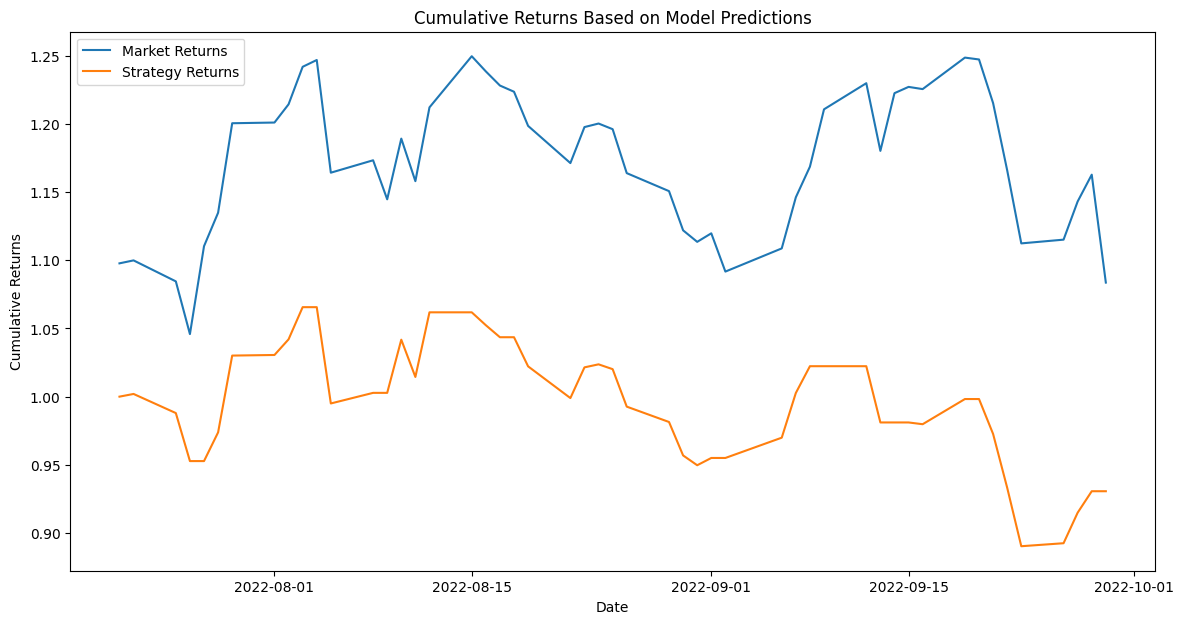

Mean Strategy Return: -0.0012
Standard Deviation Strategy Return: 0.0235
Mean Market Return: 0.0021
Standard Deviation Market Return: 0.0319
Total Strategy Profit: -0.0694
Total Market Profit: 0.0837


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate daily returns
test_data['Daily_Returns'] = test_data['Close'].pct_change()

# Initialize a column for strategy returns based on predictions
test_data['Strategy_Returns'] = predictions['Predicted_Labels'].shift(1) * test_data['Daily_Returns']

# Calculate cumulative returns
test_data['Cumulative_Market_Returns'] = (1 + test_data['Daily_Returns']).cumprod()
test_data['Cumulative_Strategy_Returns'] = (1 + test_data['Strategy_Returns']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(test_data['Date'], test_data['Cumulative_Market_Returns'], label='Market Returns')
plt.plot(test_data['Date'], test_data['Cumulative_Strategy_Returns'], label='Strategy Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Based on Model Predictions')
plt.legend()
plt.show()

# Calculate mean and standard deviation of returns
mean_strategy_return = test_data['Strategy_Returns'].mean()
std_strategy_return = test_data['Strategy_Returns'].std()

mean_market_return = test_data['Daily_Returns'].mean()
std_market_return = test_data['Daily_Returns'].std()

print(f'Mean Strategy Return: {mean_strategy_return:.4f}')
print(f'Standard Deviation Strategy Return: {std_strategy_return:.4f}')
print(f'Mean Market Return: {mean_market_return:.4f}')
print(f'Standard Deviation Market Return: {std_market_return:.4f}')

# Calculate total profitability
total_strategy_profit = test_data['Cumulative_Strategy_Returns'].iloc[-1] - 1
total_market_profit = test_data['Cumulative_Market_Returns'].iloc[-1] - 1

print(f'Total Strategy Profit: {total_strategy_profit:.4f}')
print(f'Total Market Profit: {total_market_profit:.4f}')


           Open        High         Low       Close     Volume  \
201  246.783340  250.663330  243.483337  247.500000   88864200   
202  255.106674  273.266663  254.866669  271.706665  142032300   
203  276.220001  280.786682  270.713318  272.243347  103472700   
204  272.216675  274.146667  267.399994  268.433319   64073400   
205  266.513336  267.309998  256.263336  258.859985   66820800   
206  263.809998  275.926666  261.790009  274.820007   88110000   
207  280.066681  283.299988  272.799988  280.899994   84723000   
208  280.700012  298.320007  279.100006  297.149994   95313000   
209  301.276672  311.876678  295.000000  297.276672  117042900   
210  294.003326  307.833344  292.666656  300.586670   95577600   
211  305.000000  309.549988  301.149994  307.396667   80091000   
212  311.000000  313.606659  305.000000  308.633331   72256200   
213  302.670013  304.606659  285.543335  288.170013  113172900   
214  295.000000  305.200012  289.086670  290.423340   98994000   
215  290.2

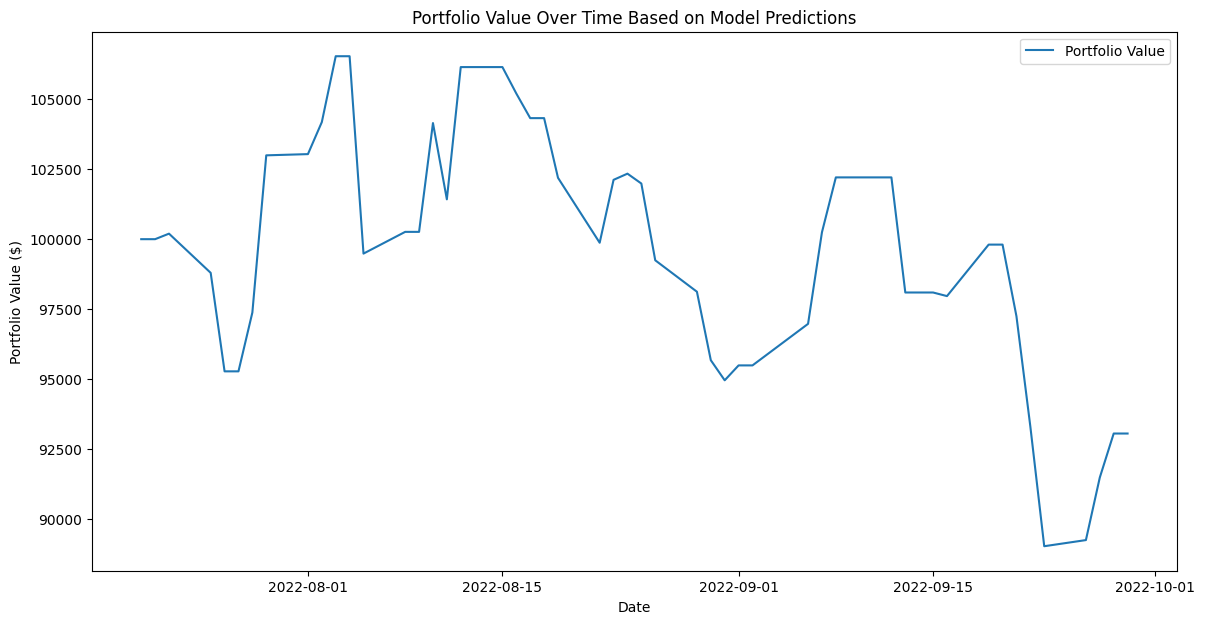

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Concatenate based on row index
merged_data = pd.concat([test_data, predictions], axis=1)

# Check merged columns to ensure correct merge
print(merged_data)

# Initialize variables
initial_capital = 100000  # starting with $100,000
capital = initial_capital
position = 0  # number of shares held
portfolio_value = capital

# List to store portfolio value over time
portfolio_values = []

# Simulate trading
for index, row in merged_data.iterrows():
    if row['Predicted_Labels'] == 1:
        # Buy signal
        if position == 0:
            # Buy as many shares as possible
            position = capital // row['Close']
            capital -= position * row['Close']
    elif row['Predicted_Labels'] == 0:
        # Sell signal
        if position > 0:
            # Sell all shares
            capital += position * row['Close']
            position = 0

    # Calculate current portfolio value
    portfolio_value = capital + position * row['Close']
    portfolio_values.append(portfolio_value)

# Add portfolio values to merged_data for analysis
merged_data['Portfolio_Value'] = portfolio_values

# Calculate total profit or loss
total_profit_or_loss = portfolio_value - initial_capital
total_return = (portfolio_value / initial_capital) - 1

print(f'Final Portfolio Value: ${portfolio_value:.2f}')
print(f'Total Profit or Loss: ${total_profit_or_loss:.2f}')
print(f'Total Return: {total_return:.2%}')

# Plot portfolio value over time
plt.figure(figsize=(14, 7))
plt.plot(merged_data['Date'], merged_data['Portfolio_Value'], label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Over Time Based on Model Predictions')
plt.legend()
plt.show()


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def simulate_trading(data, initial_capital=100000):
    capital = initial_capital
    position = 0  # number of shares held
    portfolio_value = capital
    portfolio_values = []

    for index, row in data.iterrows():
        if row['Predicted_Labels'] == 1:
            # Buy signal
            if position == 0:
                # Buy as many shares as possible
                position = capital // row['Close']
                capital -= position * row['Close']
        elif row['Predicted_Labels'] == 0:
            # Sell signal
            if position > 0:
                # Sell all shares
                capital += position * row['Close']
                position = 0
        # Calculate current portfolio value
        portfolio_value = capital + position * row['Close']
        portfolio_values.append(portfolio_value)

    # Calculate total profit or loss
    total_profit_or_loss = portfolio_value - initial_capital
    total_return = (portfolio_value / initial_capital) - 1

    return total_return, portfolio_values

# Perform multiple simulations (bootstrapping or rolling window)
n_simulations = 100
simulation_results = []

for _ in range(n_simulations):
    # You can shuffle the data or use a rolling window approach
    shuffled_data = merged_data.sample(frac=1).reset_index(drop=True)
    total_return, portfolio_values = simulate_trading(shuffled_data)
    simulation_results.append(total_return)

# Convert results to a DataFrame
simulation_results_df = pd.DataFrame(simulation_results, columns=['Total_Return'])

# Analyze the results
mean_return = simulation_results_df['Total_Return'].mean()
std_return = simulation_results_df['Total_Return'].std()
max_drawdown = simulation_results_df['Total_Return'].min()

print(f'Mean Return: {mean_return:.2%}')
print(f'Standard Deviation of Return: {std_return:.2%}')
print(f'Max Drawdown: {max_drawdown:.2%}')


Mean Return: -4.64%
Standard Deviation of Return: 15.80%
Max Drawdown: -36.85%


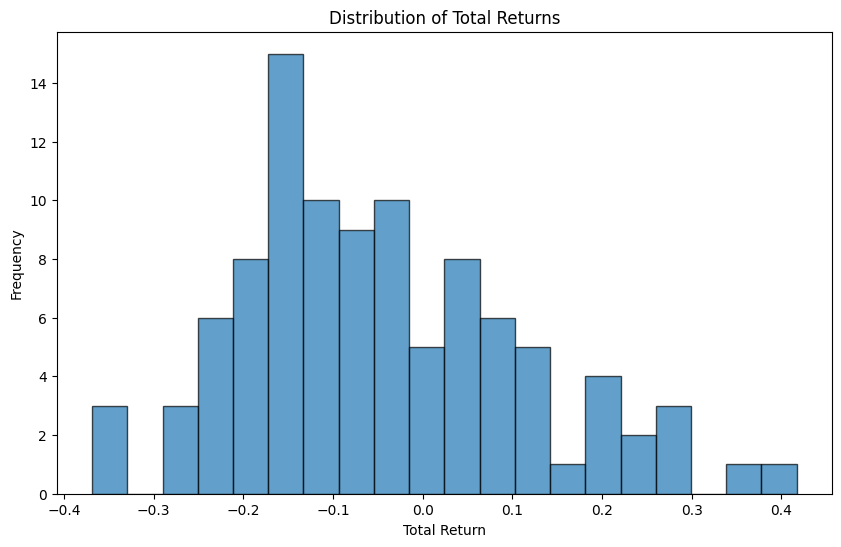

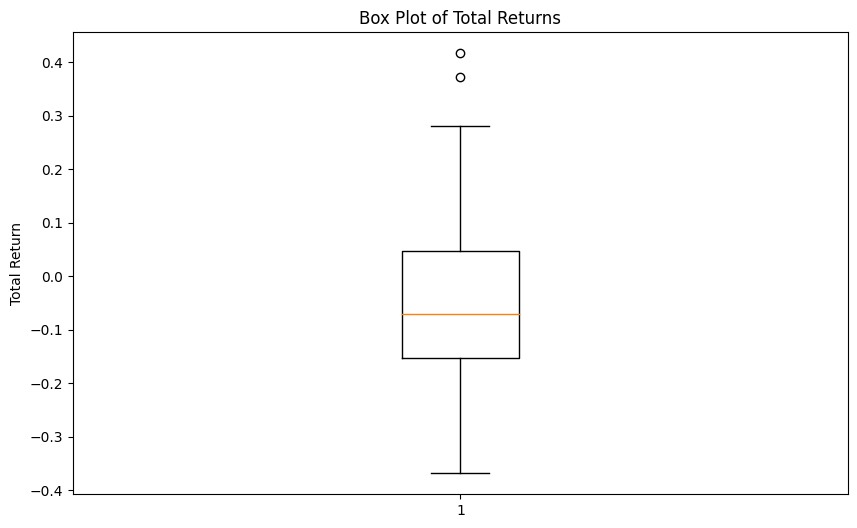

In [54]:
# Histogram of returns
plt.figure(figsize=(10, 6))
plt.hist(simulation_results_df['Total_Return'], bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Total Return')
plt.ylabel('Frequency')
plt.title('Distribution of Total Returns')
plt.show()

# Box plot of returns
plt.figure(figsize=(10, 6))
plt.boxplot(simulation_results_df['Total_Return'])
plt.ylabel('Total Return')
plt.title('Box Plot of Total Returns')
plt.show()


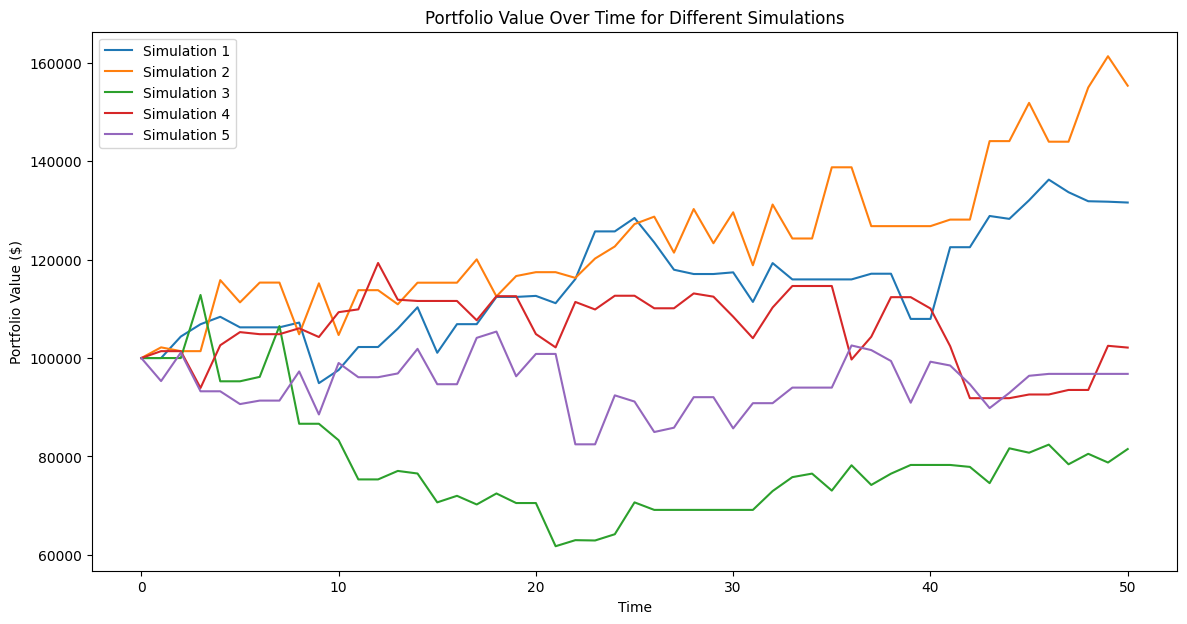

In [55]:
plt.figure(figsize=(14, 7))
for i in range(min(n_simulations, 5)):  # Plotting the first 5 simulations
    _, portfolio_values = simulate_trading(merged_data.sample(frac=1).reset_index(drop=True))
    plt.plot(portfolio_values, label=f'Simulation {i+1}')

plt.xlabel('Time')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Over Time for Different Simulations')
plt.legend()
plt.show()
